In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy, scipy.interpolate, scipy.misc, scipy.integrate
from scipy.interpolate import interp1d

import time
import sys
sys.path.append('/Users/ap/workspace/Q0-sims')

import emcee
import corner

import obs_tools as obs
import fg_tools as fg
import pk_tools as pk

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 20, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = False

# Simulated data

In [3]:
# data:
data = pd.read_pickle('./Data/data.pkl')

HI_signal = data.nobeam.HI
HI_noise = data.nobeam.noise

HI_noise_data = HI_signal + HI_noise #data.beam.HI_noise

freqs = data.freqs

#### Sims specs

In [4]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78 #Mpc/h
nx, ny, nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

#### Calculate 3D Pk

In [5]:
# HI+noise power spectrum:
HI_pk = pk.getpk(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

In [6]:
N_modes = pk.getpk(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[1]

#### Calculate multipoles and Q0

In [7]:
P0 = pk.getpkmultipoles(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
P2 = pk.getpkmultipoles(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[1]
P4 = pk.getpkmultipoles(HI_signal, w, W, nx, ny, nz, lx, ly, lz, kbins)[2]

Q0 = P0 -(1/2.)*P2 + (3/8.)*P4
Q2 = (3/4.)*(2*P2-5*P4)

In [8]:
P_noise = 14.4 #mK^2

sigmaP = (1/np.sqrt(2*N_modes)) * (P0 + P_noise)
sigmaQ = 3.5*sigmaP

## Modelling

In [9]:
#Fiducial cosmological parameters
#MULTIDARK has Planck15 

#sigma8 = 0.83
c=3e5
hubble=0.678
omegab=0.048
om0 = 0.307
omegac = om0 - omegab
H00=100*hubble
Ass=2.14e-9
nss = 0.96

gamma=0.545

In [10]:
# BACCO z=0
k_tab,pk_tab  = np.loadtxt("./Data/P_NL_bacco_z0.txt")
# CAMB HALOFIT z=0.4
from pylab import genfromtxt;  
Pk_halofit = genfromtxt('./Data/Pk_camb_halofit_z0p4.dat')
#k_halofit = Pk_halofit[:,0]
#Pk_halofit = Pk_halofit[:,1]

In [11]:
Pk_bacco = scipy.interpolate.interp1d(k_tab,pk_tab,kind='cubic')

In [12]:
THI_fid = 0.0737 #mK [confirmed by Steve]
bHI_fid = 1.1 #[confirmed by Steve]

In [13]:
#Spatially flat Universe

#Define E(z) = H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))
def Hz(zc):
    return Ez(zc)*H00
#Define the comoving distances
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0,zc)
def DA(zc):
    return rcom(zc)/(1+zc)

In [14]:
#Define the growth function in LCDM
def fg(zz):
    omz=om0*pow(1+zz,3)/pow(Ez(zz),2)
    return pow(omz,gamma)

#Get the growth factor 
def Dg_dz(zz):
    return -fg(zz)/(1+zz)

def Dgz(zc):
    ans = scipy.integrate.romberg(Dg_dz, 0.0, zc)
    return np.exp(ans)

In [15]:
# To match the MultiDark simulations let's
# work at z=0.39, and scale our initial power spectrum
# to that redshift:
zc = 0.39
z,D,f      = zc,Dgz(zc),fg(zc)
klin,plin  = np.loadtxt("./Data/pk.dat",unpack=True)
plin      *= D**2

In [16]:
plin_interp = scipy.interpolate.interp1d(klin,plin,kind='cubic')

In [17]:
NL_boost = np.genfromtxt('./Data/transfer_nonlinear.txt')

k_boost = NL_boost[:,0]
boost = NL_boost[:,1]

NL_boost_fun = scipy.interpolate.interp1d(k_boost,boost,kind='cubic')

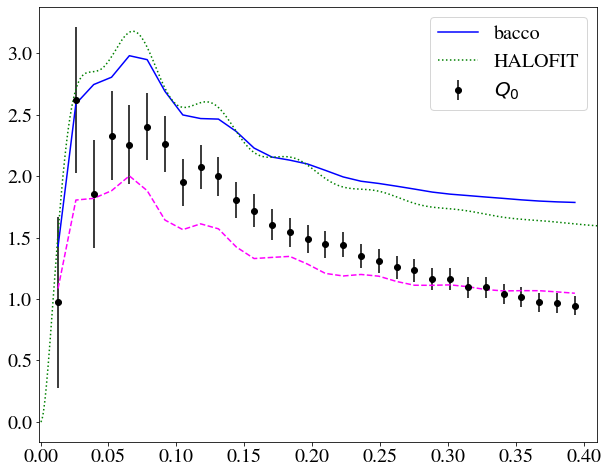

In [18]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(k, k * Q0, yerr = k * sigmaQ, ls='',marker='o',c='black', label = r'$Q_0$')

plt.plot(k, k * THI_fid**2 * bHI_fid**2 * Dgz(zc)**2 * Pk_bacco(k),ls='-',c='blue',label='bacco')
plt.plot(k, k * THI_fid**2 * bHI_fid**2 * Dgz(zc)**2 * plin_interp(k)*NL_boost_fun(k),ls='--',c='magenta')
plt.plot(Pk_halofit[:,0], Pk_halofit[:,0] * THI_fid**2 * bHI_fid**2 * Pk_halofit[:,1],ls=':',c='green',label='HALOFIT')

#factor = ((om0 + (1+zc)**(-3) * (1-om0))/0.37)**(-0.5) * ((1+zc)/1.8)**0.5
#OmHI_fid = 0.43
#THI_fid = 0.29 * factor * OmHI_fid/2.2 #mK

plt.xlim(-0.001,0.41)
#plt.ylim(-0.5,6)

plt.legend()

plt.show()